In [1]:
import os

!pip install kaggle
from google.colab import files

print("Upload your kaggle.json file")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

Upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 957MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


Data Loaded. Shape: (284807, 31)

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Percentage Distribution:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

Best epsilon: 6.34138e-08
Best F1 score on validation: 0.0240

Confusion Matrix on Validation Set:
[[49393  7471]
 [    6    92]]


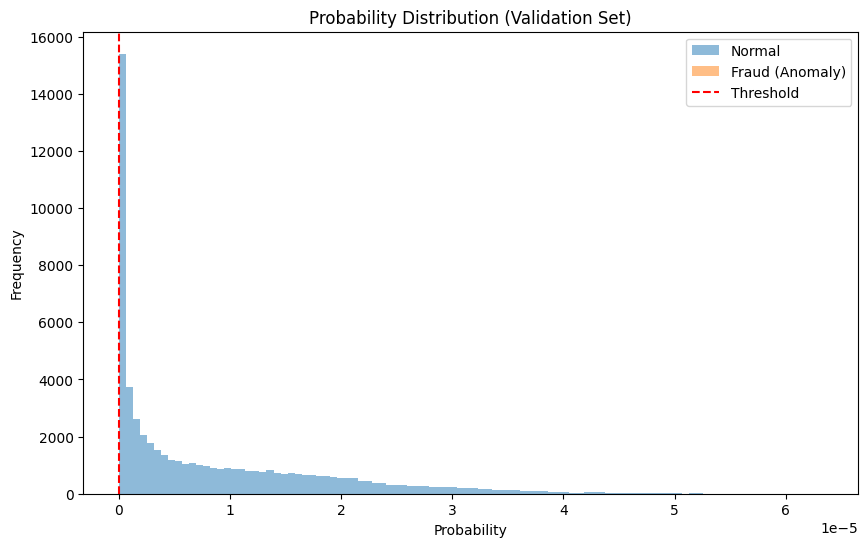

In [2]:
# Anomaly Detection with PCA and Gaussian Model using Validation Set

# 1. Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix

# 2. Load Dataset
df = pd.read_csv("creditcard.csv")
print("Data Loaded. Shape:", df.shape)

# 3. Class Distribution
print("\nClass Distribution:")
print(df['Class'].value_counts())
print("\nPercentage Distribution:")
print(df['Class'].value_counts(normalize=True) * 100)

# 4. Preprocess
features = df.drop(['Time', 'Class'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
y_true = df['Class'].values

# 5. PCA for Dimensionality Reduction
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# 6. Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_pca, y_true, test_size=0.2, stratify=y_true, random_state=42)

# 7. Estimate Gaussian Parameters from Training Set
mu = np.mean(X_train, axis=0)
sigma = np.cov(X_train, rowvar=False)
gaussian_model = multivariate_normal(mean=mu, cov=sigma)

# 8. Probability Values
p_train = gaussian_model.pdf(X_train)
p_val = gaussian_model.pdf(X_val)

# 9. Select Threshold Using Validation Set
def select_threshold(p_vals, y_true):
    best_epsilon = 0
    best_f1 = 0
    epsilons = np.linspace(min(p_vals), max(p_vals), 1000)
    for epsilon in epsilons:
        preds = (p_vals < epsilon).astype(int)
        f1 = f1_score(y_true, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    return best_epsilon, best_f1

epsilon, f1 = select_threshold(p_val, y_val)
print(f"\nBest epsilon: {epsilon:.5e}")
print(f"Best F1 score on validation: {f1:.4f}")

# 10. Predict Anomalies on Validation Set
y_pred = (p_val < epsilon).astype(int)
cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix on Validation Set:")
print(cm)

# 11. Plot Probability Distribution
plt.figure(figsize=(10, 6))
plt.hist(p_val[y_val == 0], bins=100, alpha=0.5, label='Normal')
plt.hist(p_val[y_val == 1], bins=100, alpha=0.5, label='Fraud (Anomaly)')
plt.axvline(x=epsilon, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title('Probability Distribution (Validation Set)')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()
